In [ ]:
!pip install ua-gec


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.0/36.0 MB 7.1 MB/s eta 0:00:00


In [ ]:
import ua_gec

In [ ]:
from ua_gec import Corpus, AnnotatedText

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]

from transformers import BertTokenizer, BertModel, BertTokenizerFast
import numpy as np
import torch
from transformers import DataCollatorWithPadding
from datasets import Dataset
from tqdm import tqdm
import torch.nn.functional as F
from datasets import load_dataset
import pickle
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datasets import concatenate_datasets, load_dataset

from transformers import AutoTokenizer, AutoModelForMaskedLM, XLMRobertaModel
from transformers import AutoTokenizer, AutoModelForMaskedLM, XLMRobertaModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
BATCH_SIZE = 32
EVALUTION_FREQ = 100
LEARNING_RATE = 0.00005
# LEARNING_RATE = 0.0001

In [ ]:
BATCH_SIZE

32

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
encoder = XLMRobertaModel.from_pretrained('xlm-roberta-base')

data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
def encode_sentence(text: str, tokenizer):
    return tokenizer.encode_plus(text, return_tensors='pt', padding=True, truncation=True)

list_of_classes = ["Spelling", "Punctuation", "G/Case", "G/Gender", "G/Number", "G/Aspect", "G/Tense",
                   "G/VerbVoice", "G/PartVoice", "G/VerbAForm", "G/Prep", # "G/Participle",
                   "G/UngrammaticalStructure", "G/Comparison", "G/Conjunction", "G/Particle", "Other", "G/Other",
                   "F/Style", "F/Calque", "F/Collocation", "F/PoorFlow", "F/Repetition", "F/Other"]


# індекси токенів, що відповідають зазначеному слову у sentence_word_ids
def tokens_ids(sentence_word_ids: list, pos: list):
    positions = []
    for p in pos:
        positions.extend(np.where(np.array(sentence_word_ids) == p)[0])
    return positions

def concatenate_vectors(vector1, vector2):
    return torch.cat((vector1, vector2), dim=1)

def char_to_word_index(s: str, char_index: int) -> int:
    """Return index of a word corresponding to a character position. """
    pos = -1
    word_index = -1
    while (pos := s.find(" ", pos + 1)) != -1:
        word_index += 1
        if pos >= char_index:
            return word_index
    return word_index + 1

def get_annotation_source_indexes(annotated, annotation) -> list[int]:
    text = annotated.get_original_text()
    start_word_index = char_to_word_index(text, annotation.start)
    end_word_index = char_to_word_index(text, annotation.end)
    return list(range(start_word_index, end_word_index + 1))


def get_annotation_target_indexes(annotated, annotation) -> list[int]:
    assert len(annotated.get_annotations()) == 1, \
        ("This implemention assumes there is only one annotation per text. "
         "Otherwise it won't work correctly.")
    text = annotated.get_corrected_text()
    char_start = annotation.start
    char_end = char_start + len(annotation.top_suggestion)
    start_word_index = char_to_word_index(text, char_start)
    end_word_index = char_to_word_index(text, char_end)
    return list(range(start_word_index, end_word_index + 1))


def map_error_type_to_error_label(list_of_classes, error_type):
  #print(error_type)
  return list_of_classes.index(error_type)

In [ ]:
def form_dataset_for_training(annotated_text_flatten, tokenizer):
  input_ids_source_res = []
  attention_mask_source_res = []
  input_ids_target_res = []
  attention_mask_target_res = []
  source_tokens_idxs_res = []
  target_tokens_idxs_res = []
  labels = []

  for i, example_annotated in tqdm(enumerate(annotated_text_flatten)):
      # Дістаємо єдину анотацію
      example_annotation = example_annotated.get_annotations()[0]

      # Індекси source/target слова в original/corrected реченні (відповідно)
      example_pos_source = get_annotation_source_indexes(example_annotated, example_annotation)
      example_pos_target = get_annotation_target_indexes(example_annotated, example_annotation)

      # Токенізуємо original/corrected речення
      encoded_example_source = encode_sentence(example_annotated.get_original_text(), tokenizer)
      encoded_example_target = encode_sentence(example_annotated.get_corrected_text(), tokenizer)

      # Дістаємо індекси ТОКЕНІВ source/target слова
      source_tokens_idxs = tokens_ids(encoded_example_source.word_ids(), example_pos_source)
      target_tokens_idxs = tokens_ids(encoded_example_target.word_ids(), example_pos_target)

      # Взнаємо тип помилки
      error_label = map_error_type_to_error_label(list_of_classes, example_annotation.meta['error_type'])

      def pad_tensors_to_equal_length(tensor1, tensor2, pad_token_id):
          if len(tensor1) == len(tensor2):
              return tensor1, tensor2
          max_length = max(len(tensor1), len(tensor2))
          padded_tensor1 = torch.nn.functional.pad(tensor1, (0, max_length - len(tensor1)), value=pad_token_id)
          padded_tensor2 = torch.nn.functional.pad(tensor2, (0, max_length - len(tensor2)), value=pad_token_id)
          return padded_tensor1, padded_tensor2

      # Example usage:
      # Assuming you have two tensors tensor1 and tensor2 and tokenizer.pad_token_id is the value you want to pad with
      padded_input_ids_source, padded_input_ids_target = pad_tensors_to_equal_length(encoded_example_source["input_ids"][0],
                                                                            encoded_example_target["input_ids"][0],
                                                                            tokenizer.pad_token_id)

      padded_attention_mask_source, padded_attention_mask_target = pad_tensors_to_equal_length(encoded_example_source["attention_mask"][0],
                                                                            encoded_example_target["attention_mask"][0],
                                                                            0)

      # print(tokenizer.convert_ids_to_tokens(padded_input_ids_source))
      # print(tokenizer.convert_ids_to_tokens(padded_input_ids_target))

      # input_ids_source_res.append(encoded_example_source["input_ids"][0])
      input_ids_source_res.append(padded_input_ids_source)

      #attention_mask_source_res.append(encoded_example_source["attention_mask"][0])
      attention_mask_source_res.append(padded_attention_mask_source)


      #input_ids_target_res.append(encoded_example_target["input_ids"][0])
      input_ids_target_res.append(padded_input_ids_target)


      #attention_mask_target_res.append(encoded_example_target["attention_mask"][0])
      attention_mask_target_res.append(padded_attention_mask_target)

      source_tokens_idxs_res.append(source_tokens_idxs)
      target_tokens_idxs_res.append(target_tokens_idxs)

      labels.append(error_label)

  final_df = Dataset.from_dict({"input_ids": input_ids_source_res,
                                "input_ids_target": input_ids_target_res,
                                "attention_mask": attention_mask_source_res,
                                "attention_mask_target": attention_mask_target_res,
                                "source_tokens_idxs": source_tokens_idxs_res,
                                "target_tokens_idxs": target_tokens_idxs_res,
                                "labels": labels,
                                })

  return final_df

In [ ]:
def collate_function(batch_examples, return_tensors="pt"):
    def select_columns(batch_examples, needed_columns):
        filtered_batch = [] # len(filtered_batch) = batch_size
        for example in batch_examples:
            filtered_batch.append({column: example[column] for column in needed_columns})
        return filtered_batch

    def make_mask(batch, feature):
        mask = torch.zeros_like(batch["input_ids"])
        for i, xs in enumerate(batch_examples):
            mask[i][xs[feature]] = 1
        return mask

    inputs = select_columns(batch_examples, ["input_ids",
                                            #  "input_ids_target",
                                             "attention_mask",
                                            #  "attention_mask_target"
                                             ])

    batch_inputs = data_collator(inputs)

    batch_inputs["source_tokens_mask"] = make_mask(
        batch_inputs, "source_tokens_idxs"
    )
    #print(batch_inputs["source_tokens_mask"])

    batch_inputs["target_tokens_mask"] = make_mask(
        batch_inputs, "target_tokens_idxs"
    )

    def get_feature(batch_inputs, feature, pad_token=tokenizer.pad_token_id):
      feature_values = torch.zeros_like(batch_inputs["input_ids"])
      max_length = feature_values.shape[1]

      # batch_examples - list of dictionaries, where each dict is a one instance from batch
      for i, xs in enumerate(batch_examples):
          feature_length = xs[feature].shape[0]

          # Pad xs[feature] to max_length if it's less than max_length
          if feature_length < max_length:
              padded_feature = F.pad(xs[feature], (0, max_length - feature_length), value=pad_token)
              feature_values[i] = padded_feature
          elif feature_length > max_length:
              print("⛔️ TRUNCATED")
              # If feature_length is greater than or equal to max_length, truncate xs[feature] to max_length
              feature_values[i] = xs[feature][:max_length]
          else:
              feature_values[i] = xs[feature]

      return feature_values


    #print(batch_examples["input_ids_target"])
    batch_inputs["input_ids_target"] = get_feature(batch_inputs, "input_ids_target")
    batch_inputs["attention_mask_target"] = get_feature(batch_inputs, "attention_mask_target", pad_token=0)

    # Виділення міток з функції
    labels = [float(x["labels"]) for x in batch_examples]
    batch_labels = {"labels": torch.tensor(labels)}

    # Повернення окремих пакунків даних для бачів та міток
    return batch_inputs, batch_labels

In [ ]:
class SiameseErrorTypeClassificator(nn.Module):
    """Siameese network for error type classification.
    """
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        self.num_classes = num_classes

        size_of_input = encoder.config.hidden_size * 2
        self.linear = nn.Linear(size_of_input, num_classes)

    def forward(self, batch):
        # outputs_1 = self.encoder(**inputs_1)
        # outputs_2 = self.encoder(**inputs_2)

        input_ids_source = batch["input_ids"]
        input_ids_target = batch["input_ids_target"]

        attention_mask_source = batch["attention_mask"]
        attention_mask_target = batch["attention_mask_target"]

        tokens_mask_source = batch["source_tokens_mask"]
        tokens_mask_target = batch["target_tokens_mask"]

        bert_source_outputs = self.encoder(
            input_ids=input_ids_source,
            attention_mask=attention_mask_source,
        )

        bert_target_outputs = self.encoder(
            input_ids=input_ids_target,
            attention_mask=attention_mask_target,
        )

        target_vector_1 = self._span_vector(bert_source_outputs, tokens_mask_source)
        target_vector_2 = self._span_vector(bert_target_outputs, tokens_mask_target)

        features = concatenate_vectors(target_vector_1, target_vector_2)
        logits = self.linear(features)
        log_probs = F.log_softmax(logits, dim=1)

        return log_probs


    def _span_vector(self, outputs, span_tokens):
        """Compute mean output vector for span_tokens. """

        # hidden_states = outputs.last_hidden_state[:, span_tokens, :]
        # mean = hidden_states.mean(dim=1)

        hidden_state = outputs.last_hidden_state   # (batch_size, seq_len, hidden_size)

        # Compute average hidden state of target word in each sentence
        sum_target = (span_tokens.unsqueeze(-1) * hidden_state).sum(dim=1)  # (batch_size, hidden_size)
        avg_target = sum_target / span_tokens.sum(dim=1).unsqueeze(-1)    # (batch_size, hidden_size)
        return avg_target


In [ ]:
def train(model, train_dataloader, device, optimizer, criterion, num_epochs, eval_dataloader=None):

    # Lists to store loss and accuracy values
    train_losses = []
    train_accuracies = []

    eval_losses = []
    eval_accuracies = []

    batches_since_eval = 0
    batches_since_epoch = 0

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Iterate over the training dataset
        for batch, batch_labels in tqdm(
            train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"
        ):
            # print("*")
            # Move batch data and labels to GPU
            batch = {k: v.to(device) for k, v in batch.items()}
            batch_labels = {k: v.to(device) for k, v in batch_labels.items()}

            optimizer.zero_grad()

            log_probs = model(batch)


            # class_indices = torch.tensor(batch_labels["labels"], dtype=torch.long)
            class_indices = batch_labels["labels"].long()
            loss = criterion(log_probs, class_indices)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calculate the number of correct predictions for accuracy
            _, predicted = torch.max(log_probs, 1)
            correct_predictions += (predicted == class_indices).sum().item()


            total_samples += len(batch_labels["labels"])

            # Evaluate the model every EVALUTION_FREQ batches
            batches_since_eval += 1
            batches_since_epoch += 1
            if eval_dataloader is not None and batches_since_eval >= EVALUTION_FREQ:
                epoch_loss = running_loss / batches_since_epoch
                epoch_accuracy = correct_predictions / total_samples
                eval_loss, eval_accuracy = evaluate_model(model, device, eval_dataloader, criterion)
                print(f"\nEpoch {epoch+1}, Train_Loss: {epoch_loss:.2f}, Train_Accuracy: {epoch_accuracy:.2f}, "
                      f"Eval_Loss: {eval_loss:.2f}, Eval_Accuracy: {eval_accuracy:.2f}\n")
                batches_since_eval = 0

        # Calculate average loss and accuracy for this epoch
        epoch_loss = running_loss / len(train_dataloader)
        epoch_accuracy = correct_predictions / total_samples

        # Append loss and accuracy values to lists
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Compute the evaluation loss and accuracy
        eval_loss, eval_accuracy = evaluate_model(model, device, eval_dataloader, criterion)

        # Append loss and accuracy values to lists
        eval_losses.append(eval_loss)
        eval_accuracies.append(eval_accuracy)

        # Print the average loss and accuracy for this epoch
        print(f"\nEpoch {epoch+1}, Train_Loss: {epoch_loss:.2f}, Train_Accuracy: {epoch_accuracy:.2f} "
              f"Eval_Loss: {eval_loss:.2f}, Eval_Accuracy: {eval_accuracy:.2f} \n")

    return model, train_losses, train_accuracies, eval_losses, eval_accuracies

In [ ]:
def evaluate_model(model, device, eval_dataloader, criterion):
    if eval_dataloader is None:
        return None, None

    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch, batch_labels in eval_dataloader:
            # Move batch data and labels to GPU
            batch = {k: v.to(device) for k, v in batch.items()}
            batch_labels = {k: v.to(device) for k, v in batch_labels.items()}

            log_probs = model(batch)

            # class_indices = torch.tensor(batch_labels["labels"], dtype=torch.long)
            class_indices = batch_labels["labels"].long()
            loss = criterion(log_probs, class_indices)

            running_loss += loss.item()

            # Calculate the number of correct predictions for accuracy
            _, predicted = torch.max(log_probs, 1)
            correct_predictions += (predicted == class_indices).sum().item()

            total_samples += len(batch_labels["labels"])

    # Calculate average loss and accuracy
    eval_loss = running_loss / len(eval_dataloader)
    eval_accuracy = correct_predictions / total_samples

    return eval_loss, eval_accuracy


In [ ]:
def calc_class_weights(class_frequencies, epsilon=1e-7):
    # Total number of instances
    total_instances = class_frequencies.sum()

    # Calculate class frequencies
    class_freq = class_frequencies / total_instances

    # Handle division by zero by adding epsilon to the denominator
    class_freq_denom = class_freq.clone()
    class_freq_denom[class_freq_denom == 0] = epsilon

    # Calculate class weights (inverse of class frequencies)
    class_weights = 1 / class_freq_denom

    # Normalize class weights
    class_weights /= class_weights.sum()
    return class_weights


In [ ]:
def split_df(df):
    # from datasets import Dataset
    # from sklearn.model_selection import train_test_split

    split_ratio = 0.1  # Train-test split ratio
    class_labels = sorted(df.unique('labels'))

    # Separate instances of each class
    class_instances = {label: df.filter(lambda example: example['labels'] == label) for label in
                       class_labels}

    # Initialize empty datasets for train and test
    train_datasets_list = []
    test_datasets_list = []

    # Split each class into train and test according to the desired ratio
    for label, instances in class_instances.items():
        dataset_dict = instances.train_test_split(test_size=split_ratio, seed=42)
        train_datasets_list.append(dataset_dict['train'])
        test_datasets_list.append(dataset_dict['test'])

    train_dataset = concatenate_datasets(train_datasets_list)
    test_dataset = concatenate_datasets(test_datasets_list)

    # Shuffle train and test datasets
    train_dataset = train_dataset.shuffle(seed=42)
    test_dataset = test_dataset.shuffle(seed=42)
    return train_dataset, test_dataset

In [ ]:
import pickle

In [ ]:
with open('annotated_text_flatten (2).pkl', 'rb') as f:
    loaded_data = pickle.load(f)

In [ ]:
df_no_mask = form_dataset_for_training(loaded_data[:5000], tokenizer)
# df_no_mask = form_dataset_for_training(loaded_data, tokenizer)

#dfs_no_mask = df_no_mask.train_test_split(test_size=0.1)
df_no_mask.set_format("torch")

5000it [00:07, 712.99it/s]


In [ ]:
labels_column = df_no_mask['labels']
labels_tensor = torch.tensor(labels_column)
# Count occurrences of each label
label_counts = torch.bincount(labels_tensor)
# Print number of entries for each class label
for label, count in enumerate(label_counts):
    print(f"Label {label}: {count} entries")

class_weights = calc_class_weights(label_counts)

dfs_no_mask_train, dfs_no_mask_test = split_df(df_no_mask)

Label 0: 1449 entries
Label 1: 2448 entries
Label 2: 425 entries
Label 3: 53 entries
Label 4: 40 entries
Label 5: 11 entries
Label 6: 35 entries
Label 7: 81 entries
Label 8: 36 entries
Label 9: 18 entries
Label 10: 100 entries
Label 11: 88 entries
Label 12: 36 entries
Label 13: 82 entries
Label 14: 3 entries
Label 15: 35 entries
Label 16: 60 entries


<ipython-input-22-9412fc36728c>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_tensor = torch.tensor(labels_column)


Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
dfs_no_mask_train.set_format("torch")
dfs_no_mask_test.set_format("torch")

In [ ]:
train_dataloader = DataLoader(
    dfs_no_mask_train,
    # dfs_no_mask["train"],
    # dfs_no_mask_train_50,
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=collate_function,
)

eval_dataloader = DataLoader(
    dfs_no_mask_test,
    # dfs_no_mask["test"],
    batch_size=BATCH_SIZE,
    collate_fn=collate_function
)

# for batch, labels in train_dataloader:
#     print(batch)
#     print(labels)
#     break

In [ ]:
model = SiameseErrorTypeClassificator(encoder, 17) # len(list_of_classes)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
class_weights.to(device)

criterion = nn.NLLLoss(weight=class_weights).cuda()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [ ]:
class_weights

tensor([0.0010, 0.0006, 0.0033, 0.0269, 0.0356, 0.1294, 0.0407, 0.0176, 0.0395,
        0.0791, 0.0142, 0.0162, 0.0395, 0.0174, 0.4746, 0.0407, 0.0237])

In [ ]:
device

device(type='cuda')

In [ ]:
# Training ...
model, train_losses, train_accuracies, eval_losses, eval_accuracies = train(
    model,
    train_dataloader,
    device,
    optimizer,
    criterion,
    num_epochs=5,
    eval_dataloader=eval_dataloader
)

Epoch 1/5:  34%|███▍      | 48/141 [00:51<01:39,  1.07s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 74.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 61.06 MiB is free. Process 3312 has 14.69 GiB memory in use. Of the allocated memory 13.35 GiB is allocated by PyTorch, and 1.20 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
def plot_loss_accuracy(losses, accuracies, df_name="Train"):
    # Plot loss and accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses, label=f"{df_name} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{df_name} Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label=f"{df_name} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{df_name} Accuracy")
    plt.legend()
    plt.show()

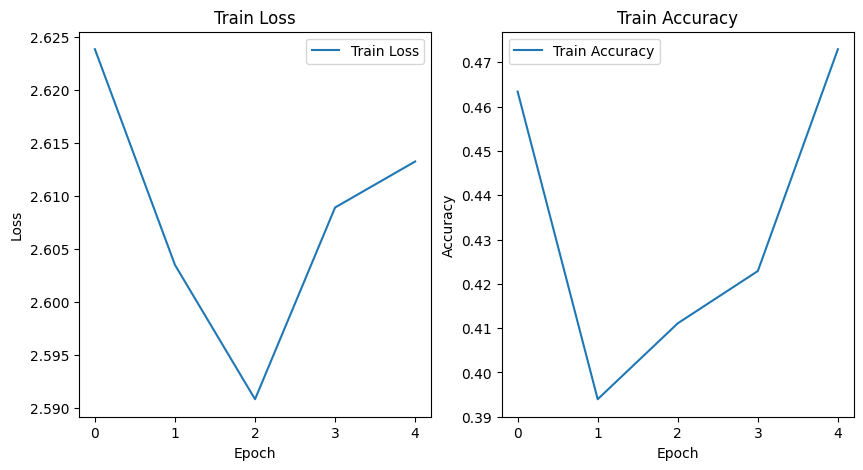

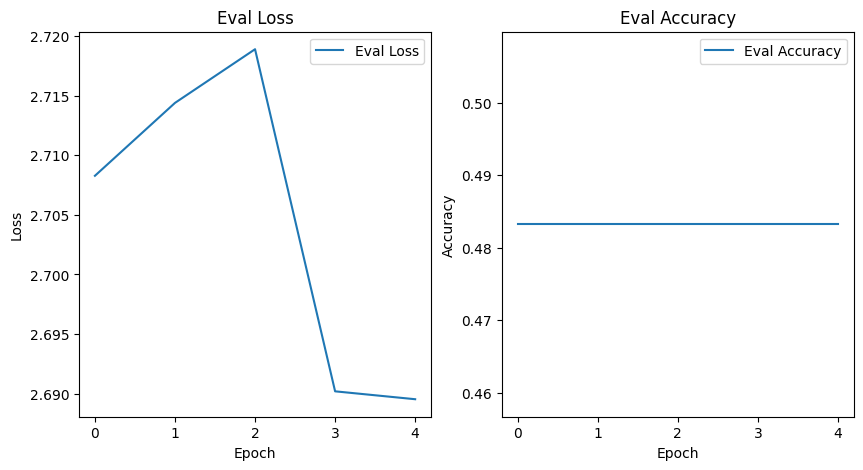

In [ ]:
plot_loss_accuracy(train_losses, train_accuracies, "Train")
plot_loss_accuracy(eval_losses, eval_accuracies, "Eval")